In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_log_error

## 读入数据

In [139]:
train_df = pd.read_csv('../input/train.csv')

test_df = pd.read_csv('../input/test.csv')

In [7]:
train_df.shape[0], test_df.shape[0]

(90615, 60411)

## 特征工程

In [8]:
com_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

In [9]:
train_idx = com_df.index[:train_df.shape[0]]
test_idx = com_df.index[train_df.shape[0]:]

### Sex

In [10]:
Sex2code = {'I': 0, 'M': 1, 'F': 2}

In [11]:
com_df['Sex_code'] = com_df['Sex'].map(Sex2code)

In [12]:
com_df.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,Sex_code
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11.0,2
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11.0,2
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6.0,0
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10.0,1
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9.0,0


### Rings

In [13]:
com_df['Rings_log1p'] = np.log1p(com_df['Rings'])

## cross_validation

## 调参

[bayesHyperTuning.py](bayesHyperTuning.py)

## 建模

In [14]:
train_df = com_df.loc[train_idx]
test_df = com_df.loc[test_idx]

In [15]:
train_cols = [c for c in train_df.columns if c not in {'id', 'Rings', 'Rings_log1p', 'Sex'}]

In [16]:
target_col = 'Rings'

In [22]:
# 记录各次试验的结果
oof_df = train_df[['id', 'Rings']].copy()
pred_df = test_df[['id']].copy()

### lightgbm

#### 默参

In [144]:
params = {
    'num_threads': 8,
    'objective': 'regression',
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'bagging_fraction': 1.0,
    'feature_fraction': 1.0,
    'reg_alpha': 0.0,
    'metric': 'l2',
    'early_stopping_rounds': 400,
}

In [ ]:
nfold = 5
folds = KFold(n_splits=nfold, shuffle=True, random_state=42)

oof = np.zeros(train_df.shape[0])
pred = np.zeros(test_df.shape[0])

for i, (trn_idx, val_idx) in enumerate(folds.split(train_df.index)):
    print(f'fold={i}', '- ' * 20)
    trn_data = lgb.Dataset(train_df.loc[trn_idx, train_cols], label=train_df.loc[trn_idx, target_col], categorical_feature=['Sex_code'])
    val_data = lgb.Dataset(train_df.loc[val_idx, train_cols], label=train_df.loc[val_idx, target_col], categorical_feature=['Sex_code'])

    model = lgb.train(params, trn_data, 10000, valid_sets=val_data, callbacks=[lgb.log_evaluation(100)])

    oof[val_idx] = model.predict(train_df.loc[val_idx, train_cols], num_iteration=model.best_iteration)
    pred += model.predict(test_df[train_cols], num_iteration=model.best_iteration) / nfold

In [148]:
mean_squared_log_error(train_df['Rings'], oof, squared=False)

0.14981370935613023

##### 抽象成函数

In [17]:
def lgb_cv(params, train_df, test_df, train_cols, target_col, log_transform=False, stratified=False, nfold=5, num_boost_round=10000):
    if stratified:
        folds = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits=nfold, shuffle=True, random_state=42)

    target = train_df[target_col]
    if log_transform:
        target = np.log1p(train_df[target_col])
    
    oof = np.zeros(train_df.shape[0])
    pred = np.zeros(test_df.shape[0])
    
    for i, (trn_idx, val_idx) in enumerate(folds.split(train_df.index, train_df.Rings.astype(int))):
    # for i, (trn_idx, val_idx) in enumerate(folds.split(train_df.index)):
        print(f'fold={i}', '- ' * 20)
        trn_data = lgb.Dataset(train_df.loc[trn_idx, train_cols], label=target.loc[trn_idx], categorical_feature=['Sex_code'])
        val_data = lgb.Dataset(train_df.loc[val_idx, train_cols], label=target.loc[val_idx], categorical_feature=['Sex_code'])
    
        model = lgb.train(params, trn_data, num_boost_round, valid_sets=val_data, callbacks=[lgb.log_evaluation(200)])
    
        oof[val_idx] = model.predict(train_df.loc[val_idx, train_cols], num_iteration=model.best_iteration)
        pred += model.predict(test_df[train_cols], num_iteration=model.best_iteration) / nfold

    if log_transform:
        oof = np.expm1(oof)
        pred = np.expm1(pred)

    cv = mean_squared_log_error(train_df['Rings'], oof, squared=False)
    return cv, oof, pred

In [25]:
params = {
    'num_threads': 8,
    'objective': 'regression',
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'bagging_fraction': 1.0,
    'feature_fraction': 1.0,
    'reg_alpha': 0.0,
    'metric': 'l2',
    'early_stopping_rounds': 400,
}

In [26]:
cv, oof, pred = lgb_cv(params, train_df, test_df, train_cols, target_col, log_transform=False, stratified=False)

fold=0 - - - - - - - - - - - - - - - - - - - - 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1586
[LightGBM] [Info] Number of data points in the train set: 72492, number of used features: 9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 9.697111
Training until validation scores don't improve for 400 rounds
[200]	valid_0's l2: 3.47244
[400]	valid_0's l2: 3.45761
[600]	valid_0's l2: 3.4644
Early stopping, best iteration is:
[382]	valid_0's l2: 3.45651
fold=1 - - - - - - - - - - - - - - - - - - - - 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-thre

In [28]:
print(cv)

tag = 'lgb_default'
oof_df[tag] = oof
pred_df[tag] = pred

0.14981370935613023


#### BayesianOptimization搜索

In [149]:
{'target': -0.14929339726508067, 'params': {'bagging_fraction': 0.8309777789028161, 'feature_fraction': 0.8188337656756874, 'learning_rate': 0.011428603279767906, 'max_leaves': 152.77240927641438, 'min_data_in_leaf': 78.74916477965401, 'reg_lambda': 2.1153678521413966}}

{'target': -0.14929339726508067,
 'params': {'bagging_fraction': 0.8309777789028161,
  'feature_fraction': 0.8188337656756874,
  'learning_rate': 0.011428603279767906,
  'max_leaves': 152.77240927641438,
  'min_data_in_leaf': 78.74916477965401,
  'reg_lambda': 2.1153678521413966}}

In [18]:
params = {
    'num_threads': 8,
    'objective': 'regression',
    'learning_rate': 0.01,
    'num_leaves': 153,
    'min_data_in_leaf': 79,
    'bagging_freq': 1,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.8,
    'reg_lambda': 2,
    'metric': 'l2',
    'early_stopping_rounds': 600,
}

In [19]:
cv, oof, pred = lgb_cv(params, train_df, test_df, train_cols, target_col, log_transform=False, stratified=False)

fold=0 - - - - - - - - - - - - - - - - - - - - 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1586
[LightGBM] [Info] Number of data points in the train set: 72492, number of used features: 9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 9.697111
Training until validation scores don't improve for 600 rounds
[200]	valid_0's l2: 3.70415
[400]	valid_0's l2: 3.4757
[600]	valid_0's l2: 3.44737
[800]	valid_0's l2: 3.4393
[1000]	valid_0's l2: 3.43742
[1200]	valid_0's l2: 3.4394
[1400]	valid_0's l2: 3.44156
Early stopping, best iteration is:
[938]	valid_0's l2: 3.43714
fold=1 - - - - - - - - - - - - - - - - - - - - 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[L

In [20]:
cv

0.14920370079442732

In [24]:
tag = 'lgb_bo'
oof_df[tag] = oof
pred_df[tag] = pred

#### Rings_log1p

In [30]:
params = {
    'num_threads': 8,
    'objective': 'regression',
    'learning_rate': 0.01,
    'num_leaves': 153,
    'min_data_in_leaf': 79,
    'bagging_freq': 1,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.8,
    'reg_lambda': 2,
    'metric': 'l2',
    'early_stopping_rounds': 600,
}

In [31]:
cv, oof, pred = lgb_cv(params, train_df, test_df, train_cols, target_col, log_transform=True, stratified=False)

fold=0 - - - - - - - - - - - - - - - - - - - - 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1586
[LightGBM] [Info] Number of data points in the train set: 72492, number of used features: 9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.329162
Training until validation scores don't improve for 600 rounds
[200]	valid_0's l2: 0.0245932
[400]	valid_0's l2: 0.022855
[600]	valid_0's l2: 0.0227037
[800]	valid_0's l2: 0.0226572
[1000]	valid_0's l2: 0.0226388
[1200]	valid_0's l2: 0.0226407
[1400]	valid_0's l2: 0.0226496
[1600]	valid_0's l2: 0.0226746
Early stopping, best iteration is:
[1077]	valid_0's l2: 0.0226345
fold=1 - - - - -

In [32]:
cv

0.1485177663531139

In [33]:
tag = 'lgb_bo_log1p'
oof_df[tag] = oof
pred_df[tag] = pred

#### StratifiedKFold

In [30]:
params = {
    'num_threads': 8,
    'objective': 'regression',
    'learning_rate': 0.01,
    'num_leaves': 153,
    'min_data_in_leaf': 79,
    'bagging_freq': 1,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.8,
    'reg_lambda': 2,
    'metric': 'l2',
    'early_stopping_rounds': 600,
}

In [36]:
cv, oof, pred = lgb_cv(params, train_df, test_df, train_cols, target_col, log_transform=True, stratified=True)

fold=0 - - - - - - - - - - - - - - - - - - - - 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1587
[LightGBM] [Info] Number of data points in the train set: 72492, number of used features: 9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.328973
Training until validation scores don't improve for 600 rounds
[200]	valid_0's l2: 0.02366
[400]	valid_0's l2: 0.0221313
[600]	valid_0's l2: 0.0220237
[800]	valid_0's l2: 0.0220021
[1000]	valid_0's l2: 0.0219977
[1200]	valid_0's l2: 0.0220156
[1400]	valid_0's l2: 0.0220406
Early stopping, best iteration is:
[916]	valid_0's l2: 0.0219964
fold=1 - - - - - - - - - - - - - - - - - - - - 
[

In [37]:
print(cv)

tag = 'lgb_bo_log1p_skf'
oof_df[tag] = oof
pred_df[tag] = pred

0.1485962186532737


### xgboost

In [38]:
def xgb_cv(params, train_df, test_df, train_cols, target_col, log_transform=False, stratified=False, nfold=5, num_boost_round=10000):
    if stratified:
        folds = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits=nfold, shuffle=True, random_state=42)

    target = train_df[target_col]
    if log_transform:
        target = np.log1p(train_df[target_col])
    
    oof = np.zeros(train_df.shape[0])
    pred = np.zeros(test_df.shape[0])
    
    for i, (trn_idx, val_idx) in enumerate(folds.split(train_df.index, train_df.Rings.astype(int))):
        print(f'fold={i}', '- ' * 20)
        trn_data = xgb.DMatrix(train_df.loc[trn_idx, train_cols], label=target.loc[trn_idx])
        val_data = xgb.DMatrix(train_df.loc[val_idx, train_cols], label=target.loc[val_idx])
        tst_data = xgb.DMatrix(test_df[train_cols])
        
        model = xgb.train(params, trn_data, num_boost_round, evals=[(val_data, 'dev')], early_stopping_rounds=400, verbose_eval=200)

        oof[val_idx] = model.predict(val_data, iteration_range=(0, model.best_iteration + 1))
        pred += model.predict(tst_data, iteration_range=(0, model.best_iteration + 1)) / nfold

    if log_transform:
        oof = np.expm1(oof)
        pred = np.expm1(pred)

    cv = mean_squared_log_error(train_df['Rings'], oof, squared=False)
    return cv, oof, pred

#### 默参

In [88]:
params = {
    'nthread': 8,
    'objective': 'reg:squarederror',    # reg:squaredlogerror
    'max_depth': 6,
    'learning_rate': 0.3,
    'min_child_weight': 1,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'alpha': 1,
    'eval_metric': 'rmse',    # rmsle
}

In [89]:
cv, oof, pred = xgb_cv(params, train_df, test_df, train_cols, target_col, log_transform=False, stratified=False)

fold=0 - - - - - - - - - - - - - - - - - - - - 
[0]	dev-rmse:2.66958
[200]	dev-rmse:1.89817
[400]	dev-rmse:1.92640
[456]	dev-rmse:1.93262
fold=1 - - - - - - - - - - - - - - - - - - - - 
[0]	dev-rmse:2.62869
[200]	dev-rmse:1.86976
[400]	dev-rmse:1.90095
[462]	dev-rmse:1.91090
fold=2 - - - - - - - - - - - - - - - - - - - - 
[0]	dev-rmse:2.64035
[200]	dev-rmse:1.88518
[400]	dev-rmse:1.91722
[454]	dev-rmse:1.92375
fold=3 - - - - - - - - - - - - - - - - - - - - 
[0]	dev-rmse:2.62569
[200]	dev-rmse:1.88388
[400]	dev-rmse:1.91146
[429]	dev-rmse:1.91430
fold=4 - - - - - - - - - - - - - - - - - - - - 
[0]	dev-rmse:2.60368
[200]	dev-rmse:1.86871
[400]	dev-rmse:1.89550
[444]	dev-rmse:1.90270


In [90]:
print(cv)

tag = 'xgb_default'
oof_df[tag] = oof
pred_df[tag] = pred

0.15108104645187145


#### 调参

In [46]:
{'target': -0.14958736584324933, 'params': {'colsample_bytree': 0.7866142255075863, 'learning_rate': 0.014675616499216792, 'max_depth': 4.306206369690987, 'min_child_weight': 22.35153866873263, 'reg_lambda': 8.041098074819361, 'subsample': 0.8960766330914962}}

{'target': -0.14958736584324933,
 'params': {'colsample_bytree': 0.7866142255075863,
  'learning_rate': 0.014675616499216792,
  'max_depth': 4.306206369690987,
  'min_child_weight': 22.35153866873263,
  'reg_lambda': 8.041098074819361,
  'subsample': 0.8960766330914962}}

In [53]:
params = {
    'nthread': 8,
    'objective': 'reg:squarederror',    # reg:squaredlogerror
    'max_depth': 4,
    'learning_rate': 0.015,
    'min_child_weight': 22.4,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'reg_lambda': 8.0,
    'eval_metric': 'rmse',    # rmsle
}

In [54]:
cv, oof, pred = xgb_cv(params, train_df, test_df, train_cols, target_col, log_transform=False, stratified=False)

fold=0 - - - - - - - - - - - - - - - - - - - - 
[0]	dev-rmse:3.17894
[200]	dev-rmse:1.96319
[400]	dev-rmse:1.91428
[600]	dev-rmse:1.90001
[800]	dev-rmse:1.89200
[1000]	dev-rmse:1.88572
[1200]	dev-rmse:1.88080
[1400]	dev-rmse:1.87726
[1600]	dev-rmse:1.87409
[1800]	dev-rmse:1.87155
[2000]	dev-rmse:1.86918
[2200]	dev-rmse:1.86767
[2400]	dev-rmse:1.86619
[2600]	dev-rmse:1.86493
[2800]	dev-rmse:1.86404
[3000]	dev-rmse:1.86329
[3200]	dev-rmse:1.86246
[3400]	dev-rmse:1.86182
[3600]	dev-rmse:1.86100
[3800]	dev-rmse:1.86047
[4000]	dev-rmse:1.85980
[4200]	dev-rmse:1.85936
[4400]	dev-rmse:1.85887
[4600]	dev-rmse:1.85856
[4800]	dev-rmse:1.85834
[5000]	dev-rmse:1.85816
[5200]	dev-rmse:1.85804
[5400]	dev-rmse:1.85793
[5600]	dev-rmse:1.85770
[5800]	dev-rmse:1.85774
[6000]	dev-rmse:1.85776
[6200]	dev-rmse:1.85747
[6400]	dev-rmse:1.85756
[6600]	dev-rmse:1.85748
[6800]	dev-rmse:1.85747
[7000]	dev-rmse:1.85742
[7200]	dev-rmse:1.85727
[7400]	dev-rmse:1.85733
[7600]	dev-rmse:1.85760
[7800]	dev-rmse:1.85772

In [55]:
print(cv)

tag = 'xgb_bo'
oof_df[tag] = oof
pred_df[tag] = pred

0.14962945624382545


#### Rings_log1p

In [56]:
params = {
    'nthread': 8,
    'objective': 'reg:squarederror',    # reg:squaredlogerror
    'max_depth': 4,
    'learning_rate': 0.015,
    'min_child_weight': 22.4,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'reg_lambda': 8.0,
    'eval_metric': 'rmse',    # rmsle
}

In [57]:
cv, oof, pred = xgb_cv(params, train_df, test_df, train_cols, target_col, log_transform=True, stratified=False)

fold=0 - - - - - - - - - - - - - - - - - - - - 
[0]	dev-rmse:0.28519
[200]	dev-rmse:0.15894
[400]	dev-rmse:0.15490
[600]	dev-rmse:0.15379
[800]	dev-rmse:0.15319
[1000]	dev-rmse:0.15275
[1200]	dev-rmse:0.15241
[1400]	dev-rmse:0.15219
[1600]	dev-rmse:0.15198
[1800]	dev-rmse:0.15179
[2000]	dev-rmse:0.15164
[2200]	dev-rmse:0.15153
[2400]	dev-rmse:0.15144
[2600]	dev-rmse:0.15135
[2800]	dev-rmse:0.15129
[3000]	dev-rmse:0.15123
[3200]	dev-rmse:0.15115
[3400]	dev-rmse:0.15109
[3600]	dev-rmse:0.15105
[3800]	dev-rmse:0.15101
[4000]	dev-rmse:0.15097
[4200]	dev-rmse:0.15093
[4400]	dev-rmse:0.15091
[4600]	dev-rmse:0.15087
[4800]	dev-rmse:0.15085
[5000]	dev-rmse:0.15084
[5200]	dev-rmse:0.15081
[5400]	dev-rmse:0.15080
[5600]	dev-rmse:0.15079
[5800]	dev-rmse:0.15078
[6000]	dev-rmse:0.15076
[6200]	dev-rmse:0.15075
[6400]	dev-rmse:0.15074
[6600]	dev-rmse:0.15073
[6800]	dev-rmse:0.15072
[7000]	dev-rmse:0.15073
[7200]	dev-rmse:0.15073
[7400]	dev-rmse:0.15072
[7600]	dev-rmse:0.15074
[7735]	dev-rmse:0.15074

In [58]:
print(cv)

tag = 'xgb_bo_log1p'
oof_df[tag] = oof
pred_df[tag] = pred

0.1489947188041356


In [230]:
nfold = 5

In [231]:
folds = KFold(n_splits=nfold, shuffle=True, random_state=42)

In [232]:
oof = np.zeros(train_df.shape[0])
pred = np.zeros(test_df.shape[0])

for i, (trn_idx, val_idx) in enumerate(folds.split(train_df.index)):
    print(f'fold={i}', '- ' * 20)
    trn_data = xgb.DMatrix(train_df.loc[trn_idx, train_cols], label=train_df.loc[trn_idx, target_col])
    val_data = xgb.DMatrix(train_df.loc[val_idx, train_cols], label=train_df.loc[val_idx, target_col])
    tst_data = xgb.DMatrix(test_df[train_cols])

    model = xgb.train(params, trn_data, 10000, evals=[(val_data, 'dev')], early_stopping_rounds=400, verbose_eval=100)

    oof[val_idx] = model.predict(val_data, iteration_range=(0, model.best_iteration + 1))
    pred += model.predict(tst_data, iteration_range=(0, model.best_iteration + 1)) / nfold

fold=0 - - - - - - - - - - - - - - - - - - - - 
[0]	dev-rmse:0.28519
[100]	dev-rmse:0.17284
[200]	dev-rmse:0.15894
[300]	dev-rmse:0.15607
[400]	dev-rmse:0.15490
[500]	dev-rmse:0.15426
[600]	dev-rmse:0.15379
[700]	dev-rmse:0.15346
[800]	dev-rmse:0.15319
[900]	dev-rmse:0.15296
[1000]	dev-rmse:0.15275
[1100]	dev-rmse:0.15257
[1200]	dev-rmse:0.15241
[1300]	dev-rmse:0.15229
[1400]	dev-rmse:0.15219
[1500]	dev-rmse:0.15208
[1600]	dev-rmse:0.15198
[1700]	dev-rmse:0.15188
[1800]	dev-rmse:0.15179
[1900]	dev-rmse:0.15173
[2000]	dev-rmse:0.15164
[2100]	dev-rmse:0.15158
[2200]	dev-rmse:0.15153
[2300]	dev-rmse:0.15148
[2400]	dev-rmse:0.15144
[2500]	dev-rmse:0.15139
[2600]	dev-rmse:0.15135
[2700]	dev-rmse:0.15132
[2800]	dev-rmse:0.15129
[2900]	dev-rmse:0.15125
[3000]	dev-rmse:0.15123
[3100]	dev-rmse:0.15119
[3200]	dev-rmse:0.15115
[3300]	dev-rmse:0.15112
[3400]	dev-rmse:0.15109
[3500]	dev-rmse:0.15106
[3600]	dev-rmse:0.15105
[3700]	dev-rmse:0.15102
[3800]	dev-rmse:0.15101
[3900]	dev-rmse:0.15099
[400

In [233]:
oof = np.expm1(oof)

In [234]:
mean_squared_log_error(train_df['Rings'], oof, squared=False)

0.1489947188041356

#### StratifiedKFold

In [59]:
params = {
    'nthread': 8,
    'objective': 'reg:squarederror',    # reg:squaredlogerror
    'max_depth': 4,
    'learning_rate': 0.015,
    'min_child_weight': 22.4,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'reg_lambda': 8.0,
    'eval_metric': 'rmse',    # rmsle
}

In [60]:
cv, oof, pred = xgb_cv(params, train_df, test_df, train_cols, target_col, log_transform=True, stratified=True)

fold=0 - - - - - - - - - - - - - - - - - - - - 
[0]	dev-rmse:0.28270
[200]	dev-rmse:0.15619
[400]	dev-rmse:0.15204
[600]	dev-rmse:0.15100
[800]	dev-rmse:0.15052
[1000]	dev-rmse:0.15019
[1200]	dev-rmse:0.14994
[1400]	dev-rmse:0.14975
[1600]	dev-rmse:0.14958
[1800]	dev-rmse:0.14946
[2000]	dev-rmse:0.14936
[2200]	dev-rmse:0.14927
[2400]	dev-rmse:0.14921
[2600]	dev-rmse:0.14915
[2800]	dev-rmse:0.14908
[3000]	dev-rmse:0.14902
[3200]	dev-rmse:0.14898
[3400]	dev-rmse:0.14896
[3600]	dev-rmse:0.14893
[3800]	dev-rmse:0.14890
[4000]	dev-rmse:0.14888
[4200]	dev-rmse:0.14887
[4400]	dev-rmse:0.14885
[4600]	dev-rmse:0.14883
[4800]	dev-rmse:0.14882
[5000]	dev-rmse:0.14881
[5200]	dev-rmse:0.14881
[5400]	dev-rmse:0.14880
[5600]	dev-rmse:0.14878
[5800]	dev-rmse:0.14878
[6000]	dev-rmse:0.14877
[6200]	dev-rmse:0.14878
[6400]	dev-rmse:0.14877
[6600]	dev-rmse:0.14878
[6709]	dev-rmse:0.14879
fold=1 - - - - - - - - - - - - - - - - - - - - 
[0]	dev-rmse:0.28267
[200]	dev-rmse:0.15678
[400]	dev-rmse:0.15293
[600

In [61]:
print(cv)

tag = 'xgb_bo_log1p_skf'
oof_df[tag] = oof
pred_df[tag] = pred

0.14889111319003048


### catboost

In [62]:
def cb_cv(params, train_df, test_df, train_cols, target_col, log_transform=False, stratified=False, nfold=5, num_boost_round=10000):
    if stratified:
        folds = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits=nfold, shuffle=True, random_state=42)

    target = train_df[target_col]
    if log_transform:
        target = np.log1p(train_df[target_col])
    
    oof = np.zeros(train_df.shape[0])
    pred = np.zeros(test_df.shape[0])
    
    for i, (trn_idx, val_idx) in enumerate(folds.split(train_df.index, train_df.Rings.astype(int))):
        print(f'fold={i}', '- ' * 20)
        trn_data = cb.Pool(train_df.loc[trn_idx, train_cols], label=target.loc[trn_idx], feature_names=train_cols, cat_features=['Sex_code'])
        val_data = cb.Pool(train_df.loc[val_idx, train_cols], label=target.loc[val_idx], feature_names=train_cols, cat_features=['Sex_code'])
    
        tst_data = cb.Pool(test_df[train_cols], feature_names=train_cols, cat_features=['Sex_code'])
    
        model = cb.train(trn_data, params, iterations=10000, evals=val_data, early_stopping_rounds=400, verbose_eval=200)
    
        oof[val_idx] = model.predict(val_data, ntree_end=model.best_iteration_)
        pred += model.predict(tst_data, ntree_end=model.best_iteration_) / nfold

    if log_transform:
        oof = np.expm1(oof)
        pred = np.expm1(pred)

    cv = mean_squared_log_error(train_df['Rings'], oof, squared=False)
    return cv, oof, pred

#### 默参

In [64]:
params = {
    'thread_count': 8,
    'objective': 'RMSE',    # reg:squaredlogerror
    'max_depth': 6,
    # 'learning_rate': 0.03,
    'min_data_in_leaf': 1,
    # 'subsample': 1.0,
    'colsample_bylevel': 1.0,
    'reg_lambda': 3,
    'eval_metric': 'RMSE',    # rmsle
}

In [65]:
cv, oof, pred = cb_cv(params, train_df, test_df, train_cols, target_col, log_transform=False, stratified=False)

fold=0 - - - - - - - - - - - - - - - - - - - - 
0:	learn: 3.1207006	test: 3.1571701	best: 3.1571701 (0)	total: 58.5ms	remaining: 9m 45s
200:	learn: 1.8916030	test: 1.9461126	best: 1.9461126 (200)	total: 2.07s	remaining: 1m 40s
400:	learn: 1.8485661	test: 1.9116108	best: 1.9116108 (400)	total: 4.06s	remaining: 1m 37s
600:	learn: 1.8228592	test: 1.8951890	best: 1.8951890 (600)	total: 5.96s	remaining: 1m 33s
800:	learn: 1.8023120	test: 1.8846323	best: 1.8846323 (800)	total: 7.9s	remaining: 1m 30s
1000:	learn: 1.7853960	test: 1.8778895	best: 1.8778895 (1000)	total: 9.85s	remaining: 1m 28s
1200:	learn: 1.7704404	test: 1.8731883	best: 1.8731529 (1199)	total: 11.8s	remaining: 1m 26s
1400:	learn: 1.7582352	test: 1.8694334	best: 1.8694120 (1397)	total: 13.8s	remaining: 1m 24s
1600:	learn: 1.7459512	test: 1.8662205	best: 1.8662205 (1600)	total: 15.8s	remaining: 1m 22s
1800:	learn: 1.7349260	test: 1.8633160	best: 1.8633160 (1800)	total: 17.8s	remaining: 1m 20s
2000:	learn: 1.7248801	test: 1.86158

In [66]:
print(cv)

tag = 'cb_default'
oof_df[tag] = oof
pred_df[tag] = pred

0.14952027812287205


#### 调参

In [67]:
{'target': -0.14920691782699697, 'params': {'colsample_bylevel': 0.444138725358572, 'learning_rate': 0.021914249401391334, 'max_depth': 5.989341011049182, 'min_data_in_leaf': 3.8619321720075757, 'reg_lambda': 5.839227436758772, 'subsample': 0.8828478540185538}}

{'target': -0.14920691782699697,
 'params': {'colsample_bylevel': 0.444138725358572,
  'learning_rate': 0.021914249401391334,
  'max_depth': 5.989341011049182,
  'min_data_in_leaf': 3.8619321720075757,
  'reg_lambda': 5.839227436758772,
  'subsample': 0.8828478540185538}}

In [68]:
params = {
    'thread_count': 8,
    'objective': 'RMSE',
    'max_depth': 6,
    'learning_rate': 0.02,
    'min_data_in_leaf': 4,
    'subsample': 0.88,
    'colsample_bylevel': 0.44,
    'reg_lambda': 5.8,
    'eval_metric': 'RMSE',
}

In [69]:
cv, oof, pred = cb_cv(params, train_df, test_df, train_cols, target_col, log_transform=False, stratified=False)

fold=0 - - - - - - - - - - - - - - - - - - - - 
0:	learn: 3.1405218	test: 3.1768071	best: 3.1768071 (0)	total: 10.4ms	remaining: 1m 44s
200:	learn: 1.9414332	test: 1.9921903	best: 1.9921903 (200)	total: 1.41s	remaining: 1m 8s
400:	learn: 1.8811675	test: 1.9366360	best: 1.9366360 (400)	total: 2.79s	remaining: 1m 6s
600:	learn: 1.8564554	test: 1.9163532	best: 1.9163532 (600)	total: 4.16s	remaining: 1m 5s
800:	learn: 1.8381722	test: 1.9035149	best: 1.9035149 (800)	total: 5.53s	remaining: 1m 3s
1000:	learn: 1.8236781	test: 1.8940745	best: 1.8940745 (1000)	total: 6.9s	remaining: 1m 2s
1200:	learn: 1.8119020	test: 1.8875648	best: 1.8875648 (1200)	total: 8.29s	remaining: 1m
1400:	learn: 1.8015661	test: 1.8825674	best: 1.8825674 (1400)	total: 9.63s	remaining: 59.1s
1600:	learn: 1.7924756	test: 1.8789450	best: 1.8789255 (1598)	total: 11s	remaining: 57.6s
1800:	learn: 1.7846382	test: 1.8762684	best: 1.8762684 (1800)	total: 12.3s	remaining: 56.2s
2000:	learn: 1.7776794	test: 1.8740562	best: 1.874

In [70]:
print(cv)

tag = 'cb_bo'
oof_df[tag] = oof
pred_df[tag] = pred

0.14934050848925068


#### Rings_log1p

In [71]:
params = {
    'thread_count': 8,
    'objective': 'RMSE',
    'max_depth': 6,
    'learning_rate': 0.02,
    'min_data_in_leaf': 4,
    'subsample': 0.88,
    'colsample_bylevel': 0.44,
    'reg_lambda': 5.8,
    'eval_metric': 'RMSE',
}

In [72]:
cv, oof, pred = cb_cv(params, train_df, test_df, train_cols, target_col, log_transform=True, stratified=False)

fold=0 - - - - - - - - - - - - - - - - - - - - 
0:	learn: 0.2817913	test: 0.2848073	best: 0.2848073 (0)	total: 10.6ms	remaining: 1m 45s
200:	learn: 0.1576536	test: 0.1613904	best: 0.1613904 (200)	total: 1.3s	remaining: 1m 3s
400:	learn: 0.1527994	test: 0.1567316	best: 0.1567316 (400)	total: 2.69s	remaining: 1m 4s
600:	learn: 0.1510028	test: 0.1551894	best: 0.1551894 (600)	total: 4.08s	remaining: 1m 3s
800:	learn: 0.1496894	test: 0.1542378	best: 0.1542378 (800)	total: 5.46s	remaining: 1m 2s
1000:	learn: 0.1487203	test: 0.1535584	best: 0.1535584 (1000)	total: 6.85s	remaining: 1m 1s
1200:	learn: 0.1479581	test: 0.1531004	best: 0.1531004 (1200)	total: 8.26s	remaining: 1m
1400:	learn: 0.1473198	test: 0.1527548	best: 0.1527548 (1400)	total: 9.66s	remaining: 59.3s
1600:	learn: 0.1466981	test: 0.1524317	best: 0.1524305 (1599)	total: 11.1s	remaining: 58.1s
1800:	learn: 0.1461987	test: 0.1522331	best: 0.1522327 (1798)	total: 12.5s	remaining: 56.7s
2000:	learn: 0.1457114	test: 0.1520397	best: 0.1

In [73]:
print(cv)

tag = 'cb_bo_log1p'
oof_df[tag] = oof
pred_df[tag] = pred

0.14872038363095877


#### StratifiedKFold

In [74]:
params = {
    'thread_count': 8,
    'objective': 'RMSE',
    'max_depth': 6,
    'learning_rate': 0.02,
    'min_data_in_leaf': 4,
    'subsample': 0.88,
    'colsample_bylevel': 0.44,
    'reg_lambda': 5.8,
    'eval_metric': 'RMSE',
}

In [75]:
cv, oof, pred = cb_cv(params, train_df, test_df, train_cols, target_col, log_transform=True, stratified=True)

fold=0 - - - - - - - - - - - - - - - - - - - - 
0:	learn: 0.2823880	test: 0.2823139	best: 0.2823139 (0)	total: 10.4ms	remaining: 1m 43s
200:	learn: 0.1582062	test: 0.1581497	best: 0.1581497 (200)	total: 1.41s	remaining: 1m 8s
400:	learn: 0.1535213	test: 0.1536274	best: 0.1536274 (400)	total: 2.81s	remaining: 1m 7s
600:	learn: 0.1517132	test: 0.1521144	best: 0.1521144 (600)	total: 4.18s	remaining: 1m 5s
800:	learn: 0.1504212	test: 0.1512589	best: 0.1512589 (800)	total: 5.54s	remaining: 1m 3s
1000:	learn: 0.1495302	test: 0.1507383	best: 0.1507383 (1000)	total: 6.88s	remaining: 1m 1s
1200:	learn: 0.1487618	test: 0.1504028	best: 0.1504026 (1199)	total: 8.25s	remaining: 1m
1400:	learn: 0.1480566	test: 0.1501218	best: 0.1501218 (1400)	total: 9.61s	remaining: 59s
1600:	learn: 0.1474522	test: 0.1498859	best: 0.1498859 (1600)	total: 11s	remaining: 57.5s
1800:	learn: 0.1469388	test: 0.1497090	best: 0.1497090 (1800)	total: 12.3s	remaining: 55.9s
2000:	learn: 0.1464190	test: 0.1495291	best: 0.1495

In [76]:
print(cv)

tag = 'cb_bo_log1p_skf'
oof_df[tag] = oof
pred_df[tag] = pred

0.14869379353170598


## Ensemble

In [83]:
from sklearn.linear_model import Ridge

In [117]:
from sklearn.model_selection import cross_val_score

In [84]:
oof_df.head()

,id,Rings,lgb_bo,lgb_default,lgb_bo_log1p,lgb_bo_log1p_skf,xgb_default,xgb_bo,xgb_bo_log1p,xgb_bo_log1p_skf,cb_default,cb_bo,cb_bo_log1p,cb_bo_log1p_skf
0,0,11.0,10.289642,10.182400,10.154723,10.361572,10.375062,10.375062,10.271809,10.226203,10.024765,10.219894,10.105420,10.371428
1,1,11.0,10.859955,11.786039,10.853195,10.588793,10.590932,10.590932,10.854418,10.634610,10.888960,10.710888,10.664319,10.401347
2,2,6.0,4.098590,4.032788,3.880086,3.923054,3.896982,3.896982,3.498899,3.634035,3.940289,3.937046,3.571966,3.615251
3,3,10.0,10.620227,10.564500,10.491419,10.240886,10.511164,10.511164,10.301860,10.063174,10.267792,10.493476,10.133761,10.009016
4,4,9.0,8.446232,8.539213,8.336120,8.347263,8.343788,8.343788,8.287245,8.333269,8.367234,8.394694,8.219236,8.397368


In [110]:
pred_df.head()

,id,lgb_bo,lgb_default,lgb_bo_log1p,lgb_bo_log1p_skf,xgb_default,xgb_bo,xgb_bo_log1p,xgb_bo_log1p_skf,cb_default,cb_bo,cb_bo_log1p,cb_bo_log1p_skf
90615,90615,9.680507,9.687270,9.735871,9.716446,9.665957,9.512101,9.511391,9.558571,9.496390,9.510598,9.614474,9.482096
90616,90616,9.555519,9.445543,9.580159,9.603779,9.435198,9.325742,9.426497,9.409044,9.547117,9.460274,9.506820,9.492851
90617,90617,10.129617,10.413110,10.001065,10.040194,10.345787,10.318898,10.146695,10.177334,10.147258,10.146205,10.081619,10.105876
90618,90618,10.658622,10.432296,10.401422,10.407098,10.398237,10.505818,10.354302,10.228295,10.598850,10.597656,10.305531,10.366432
90619,90619,7.595123,7.612846,7.545261,7.557395,7.588864,7.634484,7.595090,7.619486,7.618855,7.623218,7.586642,7.612518


In [87]:
model_tags = []
for m in ['lgb', 'xgb', 'cb']:
    model_tags += [f'{m}_default', f'{m}_bo', f'{m}_bo_log1p', f'{m}_bo_log1p_skf']
model_tags

['lgb_default',
 'lgb_bo',
 'lgb_bo_log1p',
 'lgb_bo_log1p_skf',
 'xgb_default',
 'xgb_bo',
 'xgb_bo_log1p',
 'xgb_bo_log1p_skf',
 'cb_default',
 'cb_bo',
 'cb_bo_log1p',
 'cb_bo_log1p_skf']

In [93]:
metric_df = []
for col in model_tags:
    metric_df.append([col, mean_squared_log_error(oof_df['Rings'], oof_df[col], squared=False)])
metric_df = pd.DataFrame(metric_df, columns=['model_tag', 'rmsle'])

In [94]:
metric_df

,model_tag,rmsle
0,lgb_default,0.149814
1,lgb_bo,0.149204
2,lgb_bo_log1p,0.148518
3,lgb_bo_log1p_skf,0.148596
4,xgb_default,0.151081
5,xgb_bo,0.149629
6,xgb_bo_log1p,0.148995
7,xgb_bo_log1p_skf,0.148891
8,cb_default,0.149520
9,cb_bo,0.149341


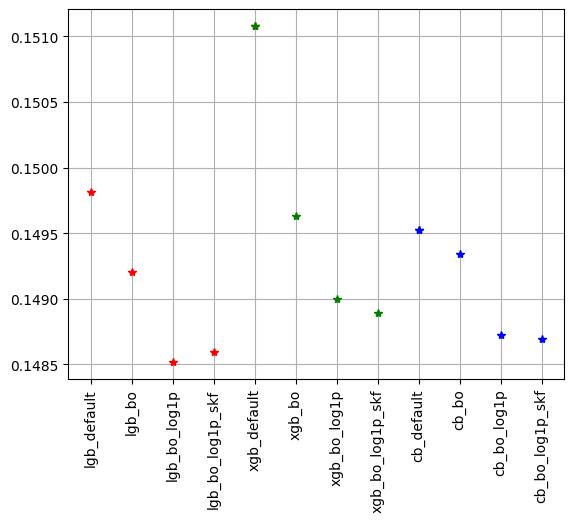

In [109]:
for i, c in zip(range(0, 12, 4), ['r', 'g', 'b']):
    df = metric_df.loc[i:(i+4)]
    plt.plot(df.index, df.rmsle, '*', c=c)

plt.xticks(ticks=metric_df.index, labels=metric_df.model_tag, rotation=90)
plt.grid()

In [130]:
ensemble_model = Ridge()

In [132]:
ensemble_model.fit(oof_df[model_tags], oof_df['Rings'])

Ridge()

In [133]:
simple_ensemble_pred = ensemble_model.predict(pred_df[model_tags])

In [134]:
simple_ensemble_pred

array([ 9.69071961,  9.55985433, 10.20571465, ..., 11.95026242,
       14.0869782 ,  8.32682338])

In [201]:
ensemble_model.coef_

array([ 0.11034582,  0.11057613,  0.23773788,  0.16545703, -0.04155965,
        0.17057234, -0.31869126,  0.20422527,  0.01563824,  0.2020739 ,
        0.01143688,  0.14652935])

In [204]:
ensemble_model.intercept_

-0.08231052545325745

In [202]:
weights = pd.Series(ensemble_model.coef_, index=model_tags)

In [205]:
weights = weights[weights >= 0.005]

([<matplotlib.patches.Wedge at 0x7f6c3ec44880>,
 [Text(1.0652045047791951, 0.2744801686791048, 'lgb_default'),
  Text(0.7995116410004638, 0.7555005863033766, 'lgb_bo'),
  Text(0.01939381061848352, 1.0998290231257286, 'lgb_bo_log1p'),
  Text(-0.8642916886623991, 0.6804409429988019, 'lgb_bo_log1p_skf'),
  Text(-1.0943888967053532, -0.11096370022687685, 'xgb_bo'),
  Text(-0.6329993878389207, -0.8996175715244517, 'xgb_bo_log1p_skf'),
  Text(-0.1214857880648594, -1.093270873708003, 'cb_default'),
  Text(0.4150589348087843, -1.0186884119471458, 'cb_bo'),
  Text(0.8442134201863004, -0.7051976327082707, 'cb_bo_log1p'),
  Text(1.038891554961212, -0.3615305478521492, 'cb_bo_log1p_skf')],
 [Text(0.58102063897047, 0.14971645564314806, '8%'),
  Text(0.43609725872752564, 0.4120912288927508, '8%'),
  Text(0.010578442155536463, 0.599906739886761, '17%'),
  Text(-0.47143183017949036, 0.37114960527207375, '12%'),
  Text(-0.5969393982029199, -0.06052565466920555, '12%'),
  Text(-0.34527239336668397, -0.4

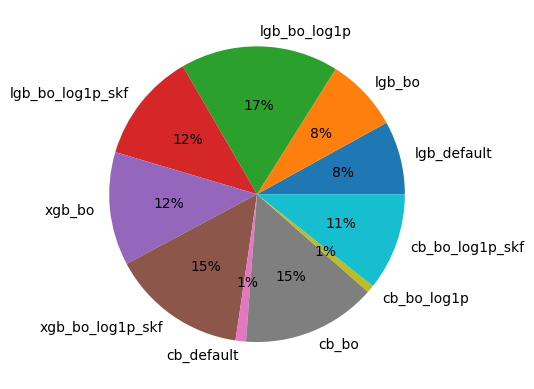

In [206]:
plt.pie(weights, labels=weights.index, autopct="%.0f%%")

In [123]:
def ensemble_cv(oof_df, pred_df, train_cols):
    nfold = 5
    folds = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=42)
    
    oof = np.zeros(oof_df.shape[0])
    pred = np.zeros(pred_df.shape[0])
    
    for i, (trn_idx, val_idx) in enumerate(folds.split(oof_df.index, oof_df.Rings.astype(int))):
        print(f'fold={i}', '- ' * 20)
        trn_X = oof_df.loc[trn_idx, train_cols]
        trn_y = oof_df.loc[trn_idx, 'Rings']

        val_X = oof_df.loc[val_idx, train_cols]
        val_y = oof_df.loc[val_idx, 'Rings']
        
        tst_X = pred_df[train_cols]

        model = Ridge()
        model.fit(trn_X, trn_y)

        oof[val_idx] = model.predict(val_X)
        pred += model.predict(tst_X) / nfold

    cv = mean_squared_log_error(oof_df['Rings'], oof, squared=False)
    return cv, pred

In [124]:
ensemble_cv, ensemble_pred = ensemble_cv(oof_df, pred_df, model_tags)

fold=0 - - - - - - - - - - - - - - - - - - - - 
fold=1 - - - - - - - - - - - - - - - - - - - - 
fold=2 - - - - - - - - - - - - - - - - - - - - 
fold=3 - - - - - - - - - - - - - - - - - - - - 
fold=4 - - - - - - - - - - - - - - - - - - - - 


In [125]:
ensemble_cv

0.1485826549524878

In [126]:
ensemble_pred

array([ 9.69072427,  9.55998489, 10.2057831 , ..., 11.95039611,
       14.08719697,  8.32680459])

## 更多数据

In [140]:
train_df = pd.read_csv('../input/train.csv')

test_df = pd.read_csv('../input/test.csv')

In [141]:
abalone_cols = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight', 'Rings']

In [142]:
ext_df = pd.read_csv('../input/abalone.data', names=abalone_cols)

In [143]:
ext_df.shape[0]

4177

In [144]:
ext_df.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [145]:
train_df.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [146]:
ext_com_df = pd.concat([train_df, ext_df, test_df], axis=0, ignore_index=True)

In [147]:
nums_train = train_df.shape[0] + ext_df.shape[0]
nums_train

94792

In [151]:
ext_train_idx = ext_com_df.index[:nums_train]
test_idx = ext_com_df.index[nums_train:]

In [156]:
Sex2code = {'I': 0, 'M': 1, 'F': 2}

In [157]:
ext_com_df['Sex_code'] = ext_com_df['Sex'].map(Sex2code)

In [158]:
ext_com_df.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,Sex_code
0,0.0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11.0,2
1,1.0,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11.0,2
2,2.0,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6.0,0
3,3.0,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10.0,1
4,4.0,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9.0,0


In [160]:
ext_train_df = ext_com_df.loc[ext_train_idx]
test_df = ext_com_df.loc[test_idx]

In [166]:
train_cols = [c for c in ext_train_df.columns if c not in {'id', 'Rings', 'Sex'}]

In [167]:
target_col = 'Rings'

In [168]:
train_cols

['Length',
 'Diameter',
 'Height',
 'Whole weight',
 'Whole weight.1',
 'Whole weight.2',
 'Shell weight',
 'Sex_code']

In [169]:
params = {
    'num_threads': 8,
    'objective': 'regression',
    'learning_rate': 0.01,
    'num_leaves': 153,
    'min_data_in_leaf': 79,
    'bagging_freq': 1,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.8,
    'reg_lambda': 2,
    'metric': 'l2',
    'early_stopping_rounds': 600,
}

In [170]:
cv, oof, pred = lgb_cv(params, ext_train_df, test_df, train_cols, target_col, log_transform=True, stratified=False)

fold=0 - - - - - - - - - - - - - - - - - - - - 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1333
[LightGBM] [Info] Number of data points in the train set: 75833, number of used features: 8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.330406
Training until validation scores don't improve for 600 rounds
[200]	valid_0's l2: 0.0243383
[400]	valid_0's l2: 0.0226028
[600]	valid_0's l2: 0.0223965
[800]	valid_0's l2: 0.0223149
[1000]	valid_0's l2: 0.0222736
[1200]	valid_0's l2: 0.0222614
[1400]	valid_0's l2: 0.022265
[1600]	valid_0's l2: 0.0222842
[1800]	valid_0's l2: 0.0223089
Early stopping, best iteration is:
[1201]	valid_0's

In [171]:
cv

0.14872039902852816

## Postprocess

In [199]:
mean_squared_log_error(ext_train_df['Rings'], oof, squared=False)

0.14872039902852816

In [184]:
def postprocess(oof, delta=0.1):
    res = oof.copy()
    oof_round = oof.round()
    diff = np.abs(oof_round - oof)
    flag = diff < delta
    res[flag] = oof_round[flag]
    return res

In [198]:
mean_squared_log_error(ext_train_df['Rings'], postprocess(oof, delta=0.06), squared=False)

0.14872666654175137

## 提交

In [62]:
sub_df = pd.read_csv('../input/sample_submission.csv')

In [63]:
sub_df.head()

,id,Rings
0,90615,10
1,90616,10
2,90617,10
3,90618,10
4,90619,10


In [64]:
(sub_df['id'] == test_df['id']).all()

True

In [113]:
# 单模型最优
pred_df['Rings'] = pred_df['lgb_bo_log1p']

In [127]:
# ensemble cv pred
pred_df['Rings'] = ensemble_pred

In [136]:
# ensemble simple pred
pred_df['Rings'] = simple_ensemble_pred

In [172]:
# more data pred cv=0.1487
pred_df['Rings'] = pred

In [173]:
cols = ['id', 'Rings']
pred_df[cols].to_csv('more_data_pred.csv', index=False, header=True)

In [175]:
!head more_data_pred.csv

id,Rings
90615,9.837206952449687
90616,9.777940900929194
90617,9.825952536578335
90618,10.639116793945018
90619,7.613494892754508
90620,9.365750582343113
90621,10.682615043884145
90622,6.050469067537613
90623,7.92449544670273


In [67]:
!head ../input/sample_submission.csv

id,Rings
90615,10
90616,10
90617,10
90618,10
90619,10
90620,10
90621,10
90622,10
90623,10
